In [12]:
import numpy as np

class BinaryFeaturesGenerator:
    """Binary distribution user state generator"""

    def __init__(self):
        pass

    def __call__(self, num_features: int):
        if num_features <= 0:
            raise ValueError("num_features must be a positive integer")
        
        # Generate a random number of 1's between 0 and num_features
        # num_ones = np.random.randint(0, num_features + 1)
        num_ones=3

        # Create a user vector with random 1's and 0's
        user_vector = np.zeros(num_features, dtype=np.float32)
        if num_ones > 0:
            # Randomly select the positions for 1's
            one_positions = np.random.choice(num_features, num_ones, replace=False)
            user_vector[one_positions] = 1

        return user_vector

# Example usage:
num_features = 14
binary_generator = BinaryFeaturesGenerator()
user_vector = binary_generator(num_features)
print(user_vector)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]


In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv
import pickle
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns

/home/aayush/.cache/pypoetry/virtualenvs/rl-recsys-J7QfXvqm-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
base_path = Path.home()/Path(os.environ.get("SAVE_PATH"))

In [16]:
# loading slateq results
ALPHA = 0.25
SEEDS = [5, 7, 46, 53, 77]
SEEDS1 = [5, 46, 53, 77]
SEEDS2 = [5, 53, 77]

In [17]:
def parse_data(data_dict: dict, alg_nam:str, seed: int)->pd.DataFrame:
    # convert from torch to float
    for k, v in data_dict.items():
        if isinstance(v, torch.Tensor):
            data_dict[k] = v.item()
        elif isinstance(v, list):
            if isinstance(v[0], torch.Tensor):
                data_dict[k] = [x.item() for x in v]
    data_df = pd.DataFrame(data_dict)
    data_df["alg_name"] = alg_nam
    data_df["seed"] = seed
    data_df = data_df.reset_index().rename(columns={"index": "episode"})
    data_df["exploration"]=data_df["exploration"]
    data_df["diversity"]=data_df["diversity"]
    return data_df

In [18]:
# load slateq results
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"diversity_slateq_300_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ", seed)
    res_df_list.append(res_df)
# concat all results
final_df = pd.concat(res_df_list)

100%|██████████| 5/5 [00:00<00:00, 55.26it/s]


In [19]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS1):
    for knearest in [20]:
        slateq_dict = pickle.load(open(base_path / Path(f"diversity_proto_slate_300_{knearest}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Proto-Slate {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
# final_df = pd.concat(res_df_list)
wp_slate_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_slate_df])

100%|██████████| 4/4 [00:00<00:00, 52.95it/s]


In [20]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS2):
    for knearest in [20]:
        slateq_dict = pickle.load(open(base_path / Path(f"diversity_proto_item_300_{knearest}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Proto-Item {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
# final_df = pd.concat(res_df_list)
wp_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_df])

100%|██████████| 3/3 [00:00<00:00, 84.02it/s]


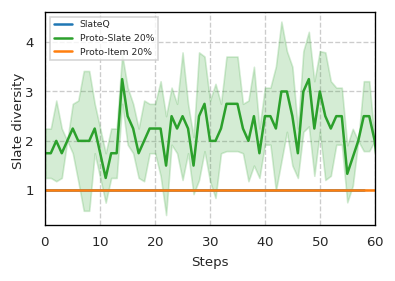

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from setup_plot import setup_plot

setup_plot(font_size=8, w_pts=256, fig_ratio=0.65)

# Set the plot style to "ticks"
sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "black"})

# Plot the mean of ep_cum_satisfaction across different seeds for each alg_name
ax = sns.lineplot(x="episode", y="diversity", hue="alg_name", errorbar="sd", data=final_df, palette=["#1f77b4", "#2ca02c","#ff7f0e", ])

legend = plt.legend(title='', fancybox=False, loc='upper left', fontsize='x-small')
# legend.get_frame().set_alpha(None)

# Set the x-axis tick format
fmt = mtick.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-3,3))
ax.xaxis.set_major_formatter(fmt)

# Add a title and axes labels
plt.xlim(0, 60)
plt.xlabel("Steps")
plt.ylabel("Slate diversity ", labelpad=0)
# plt.savefig("convergence_plot_2000.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [265]:
final_df[final_df["episode"]==58]


,episode,exploration,diversity,alg_name,seed
58,58,0.45,1,SlateQ,7
58,58,0.45,1,SlateQ,77
58,58,0.40,3,Proto-Slate 20%,53
58,58,0.40,2,Proto-Slate 20%,77
58,58,0.20,1,Proto-Item 20%,5
58,58,0.20,1,Proto-Item 20%,53
58,58,0.15,1,Proto-Item 20%,77
